In [1]:
import sys
sys.path.append("/home/ross/CytoPy")

In [2]:
from CytoPy.data.project import Project
from CytoPy.data.setup import global_init
from CytoPy.flow.cell_classifier import SklearnCellClassifier
global_init("Peritonitis")

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import logging
sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
project = Project.objects(project_id="Immunofingerprints").get()
project.list_experiments()

['Drain fluid T cells',
 'Drain fluid Leukocytes',
 'Corrected drain fluid T cells',
 'Corrected drain fluid Leukocytes']

<h1>XGBoost classification of T cell subsets</h1>

In [7]:
exp = project.load_experiment("Corrected drain fluid T cells")

In [11]:
features = ['FSC-A', 'SSC-A', 'CXCR3', 'CD161', 'CCR7', 'Va7-2',
            'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4', 'CD27']

In [12]:
params = {"learning_rate": 0.05,
          "n_estimators": 100,
          "max_depth": 4,
          "colsample_bytree": 0.75}
classifier = SklearnCellClassifier(klass="XGBClassifier",
                                   params=params,
                                   features=features,
                                   target_populations=["Vd2+ GDTs",
                                                       "MAIT cells",
                                                       "CD8+ T cells",
                                                       "CD4+ T cells"],
                                   multi_label=False,
                                   population_prefix="XGB")

In [13]:
classifier = (classifier.load_training_data(experiment=exp,
                                          reference='Training Data',
                                          root_population='root')
              .transform(method="logicle")
              .scale()
              .build_model()
              .compute_class_weights())

In [14]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,
                      random_state=42,
                      shuffle=True)

In [15]:
training_results, testing_results = classifier.fit_cv(skf)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
training_u = pd.DataFrame(training_results).mean()
training_std = pd.DataFrame(training_results).std()
training_u.name = "Average training score"
training_std.name = "Training score SD"
pd.DataFrame([training_u, training_std])

,balanced_accuracy_score,f1_weighted,roc_auc_score
Average training score,0.998883,0.999628,0.999992
Training score SD,0.000105,0.000032,0.000002


In [17]:
testing_u = pd.DataFrame(testing_results).mean()
testing_std = pd.DataFrame(testing_results).std()
testing_u.name = "Average training score"
testing_std.name = "Training score SD"
pd.DataFrame([testing_u, testing_std])

,balanced_accuracy_score,f1_weighted,roc_auc_score
Average training score,0.998065,0.999382,0.999956
Training score SD,0.000600,0.000139,0.000035


[learning_curve] Training set sizes: [ 16174  32349  48523  64698  80873  97047 113222 129396 145571 161746]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


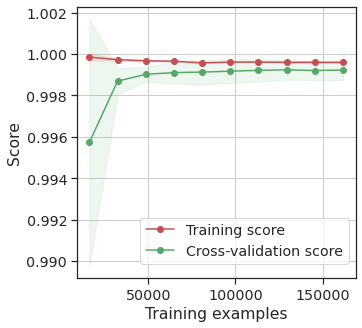

In [31]:
ax = classifier.plot_learning_curve(n_jobs=-1, scoring="accuracy")
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.25))
plt.savefig("figures/xgboost/learning_curve_tcells.png", 
            dpi=300, 
            facecolor="white", 
            bbox_inches="tight")

In [32]:
classifier.fit()

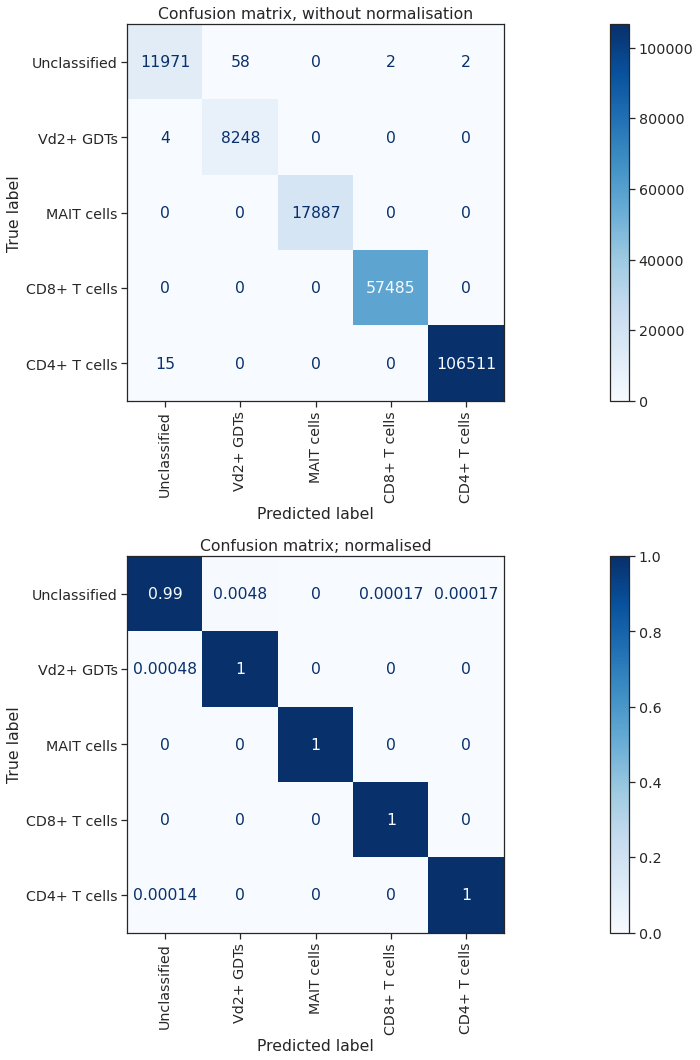

In [33]:
classifier.plot_confusion_matrix(figsize=(30, 15))
plt.savefig("figures/xgboost/confusion_matrix_tcells.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

In [34]:
from tqdm.notebook import tqdm
for s in tqdm(exp.list_samples()):
    if s == "Training Data":
        continue
    prediction = classifier.predict(experiment=exp,
                                    sample_id=s,
                                    root_population="root",
                                    return_predictions=False)[0]
    prediction.save()

  0%|          | 0/45 [00:00<?, ?it/s]

<h1>XGBoost classification of Leukocyte subsets</h1>

In [5]:
exp = project.load_experiment("Corrected drain fluid Leukocytes")

In [6]:
features = ['FSC-A',
             'SSC-A',
             'CD14',
             'CD16',
             'Siglec8',
             'CD3',
             'CD1c',
             'CD15',
             'HLA-DR',
             'CD116',
             'CD19']

In [8]:
exp.get_sample("Training Data").print_population_tree()

root
├── CD116-
│   ├── CD3+ CD19-
│   │   └── T cells
│   └── CD3- CD19+
│       └── B cells
└── CD116+
    ├── CD15- Siglec8-
    │   └── macrophages/monocytes
    │       ├── CD1c+
    │       │   └── DCs
    │       └── CD1c- CD14+
    │           └── Monocytes
    ├── CD15+ Siglec8-
    │   └── Neutrophils
    └── CD15- Siglec8+
        └── Eosinophils


In [9]:
params = {"learning_rate": 0.05,
          "n_estimators": 100,
          "max_depth": 4,
          "colsample_bytree": 0.75}
classifier = SklearnCellClassifier(klass="XGBClassifier",
                                   params=params,
                                   features=features,
                                   target_populations=["T cells",
                                                       "B cells",
                                                       "DCs",
                                                       "Monocytes",
                                                       "Neutrophils",
                                                       "Eosinophils"],
                                   multi_label=False,
                                   population_prefix="XGB")

In [10]:
classifier = (classifier.load_training_data(experiment=exp,
                                          reference='Training Data',
                                          root_population='root')
              .transform(method="logicle")
              .scale()
              .build_model()
              .compute_class_weights())

In [11]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,
                      random_state=42,
                      shuffle=True)

In [12]:
training_results, testing_results = classifier.fit_cv(skf)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
training_u = pd.DataFrame(training_results).mean()
training_std = pd.DataFrame(training_results).std()
training_u.name = "Average training score"
training_std.name = "Training score SD"
pd.DataFrame([training_u, training_std])

,balanced_accuracy_score,f1_weighted,roc_auc_score
Average training score,0.991838,0.977569,0.999704
Training score SD,0.000102,0.000282,0.000007


In [14]:
testing_u = pd.DataFrame(testing_results).mean()
testing_std = pd.DataFrame(testing_results).std()
testing_u.name = "Average training score"
testing_std.name = "Training score SD"
pd.DataFrame([testing_u, testing_std])

,balanced_accuracy_score,f1_weighted,roc_auc_score
Average training score,0.990976,0.976829,0.999649
Training score SD,0.000235,0.000724,0.000048


[learning_curve] Training set sizes: [ 18573  37146  55720  74293  92867 111440 130013 148587 167160 185734]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.5min finished


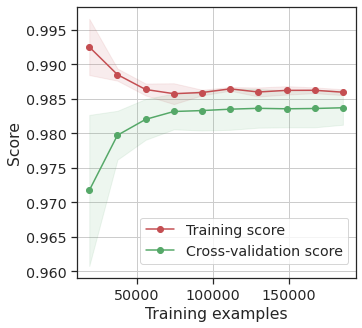

In [15]:
ax = classifier.plot_learning_curve(n_jobs=-1, scoring="accuracy")
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.25))
plt.savefig("figures/xgboost/learning_curve_leukocytes.png", 
            dpi=300, 
            facecolor="white", 
            bbox_inches="tight")

In [16]:
classifier.fit()

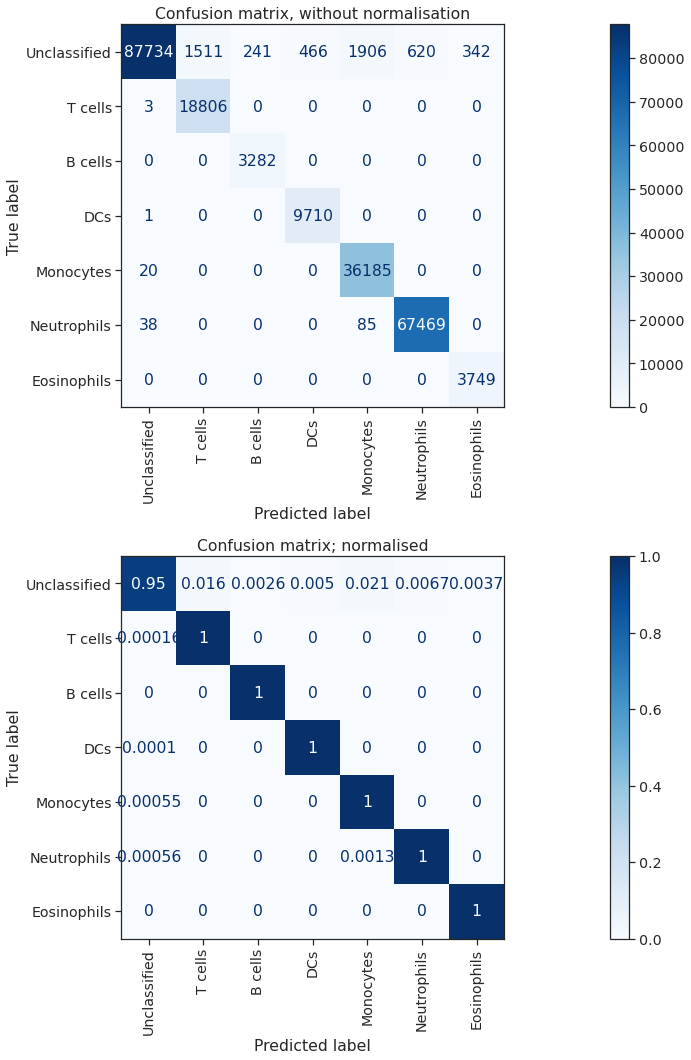

In [17]:
classifier.plot_confusion_matrix(figsize=(30, 15))
plt.savefig("figures/xgboost/confusion_matrix_leukocytes.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

In [18]:
from tqdm.notebook import tqdm
for s in tqdm(exp.list_samples()):
    if s == "Training Data":
        continue
    prediction = classifier.predict(experiment=exp,
                                    sample_id=s,
                                    root_population="root",
                                    return_predictions=False)[0]
    prediction.save()

  0%|          | 0/48 [00:00<?, ?it/s]